In [1]:
%load_ext autoreload
%autoreload 2

# Processing Sensitivity Analysis Outputs

In [2]:
import os
from pathlib import Path


ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
import sys
from omegaconf import OmegaConf
import polars as pl

sys.path.append(str(ROOT))

## Load All Results Files

In [3]:
regex_pattern = "data/SA1/SobolSensitivityAnalysisCars-*/**/results.parquet"

In [4]:
results_df = []
for file_ in ROOT.glob(regex_pattern):
    print(file_)
    df = pl.read_parquet(file_)

    # read config
    config_file = file_.parent / "config.yaml"
    config = OmegaConf.load(config_file)

    df = df.with_columns(N=pl.lit(config.Blocks.SobolSequenceConfig.N))

    sample_df = pl.read_parquet(file_.parent / "sobol_sequence.parquet").with_row_count(
        "run_id"
    )

    results_df.append(df.join(sample_df, on="run_id"))

results_df = pl.concat(results_df)
repr_conf = config

/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-64/results.parquet
/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-4/results.parquet
/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-2048/results.parquet
/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-128/results.parquet
/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-256/results.parquet
/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-1024/results.parquet
/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-512/results.parquet
/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-16/results.parquet
/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-32/results.parquet
/home/max/Development/sa-traffic-sim/data/SA1/SobolSensitivityAnalysisCars-8/results.parquet


In [5]:
from src.sa_helpers.metrics import energy_2_fuel

results_df = results_df.pipe(energy_2_fuel, )

## Perform Sobol Analysis

In [6]:
from SALib.analyze import sobol
from SALib.sample import sobol as sobol_sample
from sumo_pipelines.blocks.producers.config import SobolSequenceConfig

In [7]:
problem = SobolSequenceConfig.build_sobol_dict(repr_conf.Blocks.SobolSequenceConfig)
second_order = repr_conf.Blocks.SobolSequenceConfig.calc_second_order


def get_sa_results(r_df, problem, column, second_order=False):
    return sobol.analyze(
        problem,
        r_df[column].to_numpy(),
        calc_second_order=second_order,
        seed=repr_conf.Metadata.random_seed,
    )


def get_sa_results_df(results_df, problem, columns, second_order=False):
    for n, n_df in results_df.group_by("N"):
        sa_results = {}
        for column in columns:
            sa_results[column] = get_sa_results(n_df, problem, column, second_order)

        sobol_df = pl.DataFrame(
            {
                "N": [n for _ in range(len(problem["names"]))],
                "names": problem["names"],
                **{
                    f"{col}_{sa_type}": sa_results[col][sa_type]
                    for col in columns
                    for sa_type in ["S1", "ST", "S1_conf", "ST_conf"]
                },
            }
        )

        yield sobol_df

In [8]:
target_cols = set(results_df.columns).intersection(
    set(repr_conf.Pipeline.pipeline[0].consumers[8].config.keys())
) | set(
    [
        "cropped_per_vehicle_fuel",
        "total_fuel_l_cropped",
    ]
)

sobol_df = pl.concat(
    get_sa_results_df(results_df, problem, target_cols, second_order=second_order)
)

/home/max/.pyenv/versions/3.9.18/envs/sa-traffic-sim/lib/python3.9/site-packages/SALib/analyze/sobol.py:207: RuntimeWarning: divide by zero encountered in divide
  return np.mean(B * (AB - A), axis=0) / np.var(y, axis=0)
/home/max/.pyenv/versions/3.9.18/envs/sa-traffic-sim/lib/python3.9/site-packages/SALib/analyze/sobol.py:207: RuntimeWarning: invalid value encountered in divide
  return np.mean(B * (AB - A), axis=0) / np.var(y, axis=0)
/home/max/.pyenv/versions/3.9.18/envs/sa-traffic-sim/lib/python3.9/site-packages/SALib/analyze/sobol.py:220: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(y, axis=0)
/home/max/.pyenv/versions/3.9.18/envs/sa-traffic-sim/lib/python3.9/site-packages/SALib/analyze/sobol.py:220: RuntimeWarning: invalid value encountered in divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(y, axis=0)


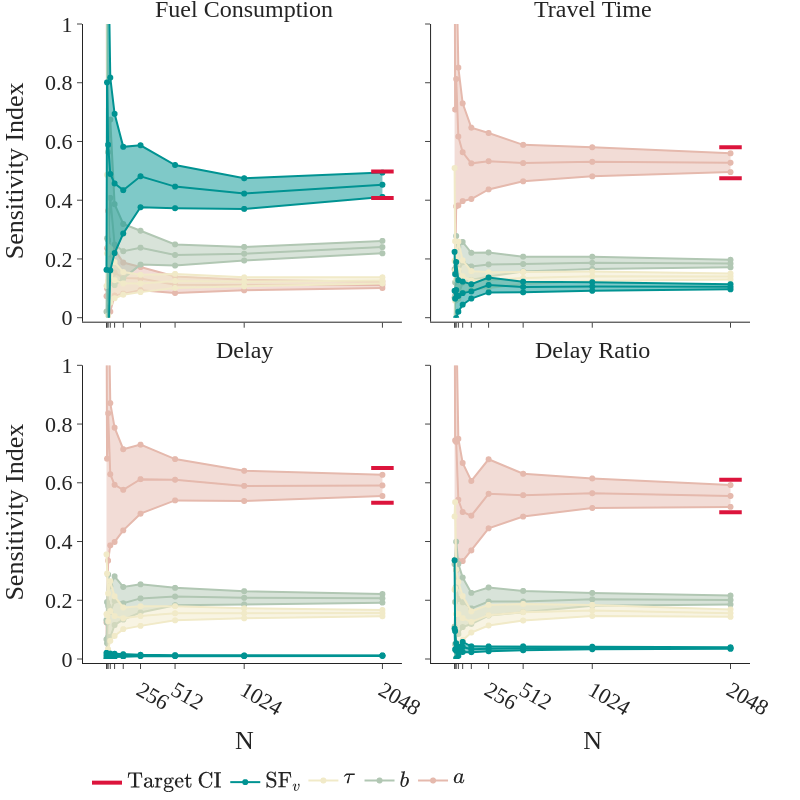

In [45]:
from src.plotting.plots import plot_si_v_n
from src.plotting.helpers import plotly_2_image

fig = plot_si_v_n(
    sobol_df.with_columns(
        (pl.col("N") * (problem["num_vars"] + 2)).alias('num_sims'),
    ),
    plot_variables=["Accel", "Decel", "Tau", "speedFactor"],
    plot_columns=[
        "cropped_per_vehicle_fuel_ST",
        "average_travel_time_ST",
        "average_delay_ST",
        "delay_ratio_ST",
    ],
    pretty_columns=[
        "Fuel Consumption",
        "Travel Time",
        "Delay",
        "Delay Ratio",
    ],
)


plotly_2_image(fig,  width=800, height=800, scale=1)
